In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

In [21]:
# get the image and their corresponding labels
dataset_path = Path("/home/nikhil/Nikhil/ElectronicsDev/DVCON2025/AI_Model_Res/Dataset/WM28kL_224x224/")
images = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: x.parents[0].stem, images))
# print(len(labels))
# print(images)

In [20]:
# getting the dataset in a Dataframe for convenience

images = pd.Series(images, name="Images").astype(str)
labels = pd.Series(labels, name="Labels").astype(str)

data = pd.concat([images, labels], axis = 1)
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)
data.head()

,Images,Labels
0,/home/nikhil/Nikhil/ElectronicsDev/DVCON2025/A...,Edge-Ring
1,/home/nikhil/Nikhil/ElectronicsDev/DVCON2025/A...,Edge-Ring
2,/home/nikhil/Nikhil/ElectronicsDev/DVCON2025/A...,Edge-Loc
3,/home/nikhil/Nikhil/ElectronicsDev/DVCON2025/A...,Center
4,/home/nikhil/Nikhil/ElectronicsDev/DVCON2025/A...,Loc


/tmp/ipykernel_32871/967122303.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(data.Images[i]))


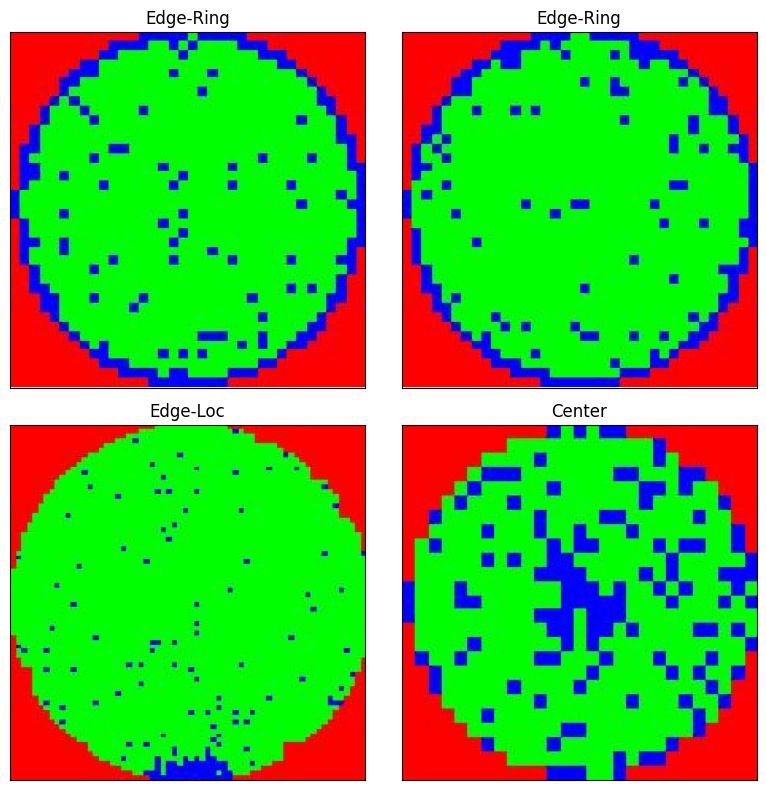

In [ ]:

# small sample of the data
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(imageio.imread(data.Images[i]))
  ax.set_title(data.Labels[i])
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()

# Data Augmentations

In [24]:
# Using a tensorflow ImageDataGenerator for generating the training data
# This will handle the io along with any augmentations to be done to the images

# currently testing MobileNet

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2

train_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet_v2.preprocess_input,
    validation_split = 0.1
)

test_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet_v2.preprocess_input
)

In [27]:
# generating the required datasets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    data, 
    train_size=0.9, 
    shuffle=True, 
    random_state=42,
    stratify=data[["Labels"]]
)

train = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test = test_generator_mobile_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 23058 validated image filenames belonging to 9 classes.
Found 2562 validated image filenames belonging to 9 classes.
Found 2847 validated image filenames belonging to 9 classes.


## Building the model

In [38]:
from tensorflow.keras.applications import MobileNetV2

mobilenetv2 = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    alpha=1.0,
    pooling='avg',
    weights='imagenet'
)
# mobilenetv2.summary()

In [35]:
#freezing the model training

mobilenetv2.trainable = False

In [45]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(256, activation='relu')(mobilenetv2.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(9, activation='softmax')(x)

mobilenetv2_wm28kL = Model(inputs=mobilenetv2.input, outputs=outputs)
mobilenetv2_wm28kL.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [46]:
CHECKPOINTS = Path("./checkpoints.keras")
CHECKPOINTS.mkdir(exist_ok=True)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# training
results = mobilenetv2_wm28kL.fit(
    train,
    validation_data = validation,
    batch_size = 32,
    epochs = 20,
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), 
        ReduceLROnPlateau(patience=2),
        ModelCheckpoint(
            str(CHECKPOINTS),
            monitor="val_loss",
            save_best_only=True
        ),
    ]
)

Epoch 1/20
 20/721 ━━━━━━━━━━━━━━━━━━━━ 20:55 2s/step - categorical_accuracy: 0.4146 - loss: 1.6479

KeyboardInterrupt: 